Abgabe von: Mat.Nr.: 9452857 & 1113800

Before doing anything installing all needed dependencies

# Software requirements

Version	Python version	Compiler	Build tools	cuDNN	CUDA<br>
tensorflow-2.16.1	3.9-3.12	Clang 17.0.6	Bazel 6.5.0	8.9	12.3

!pip3 install pandas
!pip3 install scikit-learn
!pip3 install tensorflow==2.16.1
!pip3 install keras-tuner
!pip3 install matplotlib
!pip3 install imblearn

# Aufgabe 1

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Import data

In [2]:
white_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-white.csv", delimiter=";")
red_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-red.csv", delimiter=";")

In [3]:
white_raw

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Split wine in Test and Training Data (80% / 20%)

In [4]:
white_training_Data, white_test_data, white_training_scores, white_test_scores = (train_test_split(white_raw.drop("quality", axis=1), white_raw['quality'],test_size=0.2, random_state=39))

red_training_Data, red_test_data, red_training_scores, red_test_scores = (train_test_split(red_raw.drop("quality", axis=1), red_raw['quality'],test_size=0.2, random_state=39))

Normalize the Data
Standard Scaler to Scale around 0
MIN May to Scale this than between 0-1

Some Functionality as tensorflow Normalization Layer

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, normalize, MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=39)
white_training_Data, white_training_scores = ros.fit_resample(white_training_Data, white_training_scores)
red_training_Data, red_training_scores = ros.fit_resample(red_training_Data, red_training_scores)

pipeline = Pipeline([
    ('scaler1', StandardScaler()),
    ('scaler2', MinMaxScaler())
])

white_training_Data_scaled = np.array(pipeline.fit_transform(white_training_Data))
white_training_scores = np.array(white_training_scores)
white_test_data_scaled = np.array(pipeline.transform(white_test_data))
white_test_scores = np.array(white_test_scores)

red_training_Data_scaled = np.array(pipeline.fit_transform(red_training_Data))
red_training_scores = np.array(red_training_scores)
red_test_data_scaled = np.array(pipeline.transform (red_test_data))
red_test_scores = np.array(red_test_scores)


In [6]:
white_training_Data_scaled

array([[0.26923077, 0.2254902 , 0.22289157, ..., 0.47272727, 0.20238095,
        0.12903226],
       [0.375     , 0.23529412, 0.37349398, ..., 0.37272727, 0.26190476,
        0.14516129],
       [0.23076923, 0.07843137, 0.19277108, ..., 0.45454545, 0.22619048,
        0.48387097],
       ...,
       [0.50961538, 0.18627451, 0.27108434, ..., 0.43636364, 0.28571429,
        0.38709677],
       [0.31730769, 0.17647059, 0.29518072, ..., 0.59090909, 0.23809524,
        0.79032258],
       [0.26923077, 0.2745098 , 0.1746988 , ..., 0.62727273, 0.46428571,
        0.70967742]])

# Aufgabe 3

## General Model definition

In [7]:
from math import sqrt

import keras
from keras import layers
from keras.src.models.cloning import clone_model

import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold

import keras_tuner

In [8]:
#Check and Print Tensorflow GPU Availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_loss(keras_regressor_model):
  plt.plot(keras_regressor_model.history['loss'], label='loss')
  plt.plot(keras_regressor_model.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [Wine Quality Score]')
  plt.legend()
  plt.grid(True)
  plt.show()
  
def plot_metrics(test_scores, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_scores, test_predictions)
    plt.xlabel('True Values [winequality-white]')
    plt.ylabel('Predictions [winequality-white]')
    lims = [0, 10]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()
    
    cm = confusion_matrix(test_scores, test_predictions.round(), labels=[0, 1,2,3,4,5,6,7,8,9,10])
    cm_disp = ConfusionMatrixDisplay(cm)
    cm_disp.plot()

In [10]:
def create_model_tuner(hp, learning_rate):    
    # Konfiguriere die Verteilungsstrategie
    input_layer = layers.Input(shape=(11,))
    model = keras.Sequential([
        input_layer       
    ])
    
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=2, max_value=330, step=2),
                activation='relu',
            )
        )
        model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1))#output
    
    model.compile(loss=keras.losses.mean_squared_error,
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[keras.metrics.R2Score])      
    
    return model

In [11]:
import concurrent.futures
def fit_and_evaluate_model(model: keras.Sequential, x_train, y_train, x_test, y_test, **kwargs):
    model_history = model.fit(x_train, y_train, batch_size=64, epochs=500, validation_data=(x_test, y_test), verbose=0, **kwargs)
    return model_history
    

def evaluate_model_cv(learning_rate, model, training_data, training_scores, **kwargs):
    cv_scores = []
    models_history = []
    
    kfold = KFold(n_splits=5, shuffle=True) #Cross Validation cv=5
    for i, (train_index, test_index) in enumerate(kfold.split(training_data, training_scores)):
        local_model = clone_model(model)
        #model needs recompiling after clones - recompiled with same parameters
        local_model.compile(
            loss=keras.losses.mean_squared_error, 
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
            metrics=[keras.metrics.R2Score])  

        model_history = fit_and_evaluate_model(local_model, training_data[train_index], training_scores[train_index], training_data[test_index], training_scores[test_index], **kwargs)
        score = model_history.history['val_r2_score'][-1]
        print(score)
        cv_scores.append(score)
        
    cv_scores = np.array(cv_scores)
    cv_score_mean = np.mean(cv_scores)    
    return cv_score_mean


def evaluate_model_cv_print(hp, training_data, training_scores, valid_data, valid_scores,  **kwargs):
    cv_scores = []
    models_history = []
    
    kfold = KFold(n_splits=5, shuffle=True) #Cross Validation cv=5
    for i, (train_index, test_index) in enumerate(kfold.split(training_data, training_scores)):
        local_model = HyperRegressor().build(hp)
        
        model_history = local_model.fit(training_data[train_index], training_scores[train_index], batch_size=64, epochs=512, validation_data=(training_data[test_index], training_scores[test_index]), verbose=0, **kwargs)
        cv_scores.append(model_history.history['val_r2_score'][-1])
        models_history.append((local_model, model_history))
        
    cv_scores = np.array(cv_scores)
        
    print('\r\nCross Validation')
    print(f'- R^2: {cv_scores}')
    print(f'- R^2 Durchschnittlicher: {np.mean(cv_scores):.4f}')
    print(f'- R^2 Standardabweichung: {np.std(cv_scores):.4f}')
    print('\r\n')
    
    #get best model
    best_model_index = np.argmax(cv_scores)   #get best r2 score model
    optimal_model = models_history[best_model_index]
    
    predicted_test_scores = optimal_model[0].predict(valid_data)
    
    r2_score_test = r2_score(valid_scores, predicted_test_scores)
    rmse_test = sqrt(mean_squared_error(valid_scores, predicted_test_scores))
    mape_test = mean_absolute_percentage_error(valid_scores, predicted_test_scores)
    
    print('Test:')
    print(f'- R^2: {r2_score_test:.4f}')
    print(f'- RMSE: {rmse_test:.2f}')
    print(f'- MAPE: {mape_test:.2%}')
    
    plot_loss(optimal_model[1])
    plot_metrics(valid_scores, predicted_test_scores)
    
    return cv_scores, optimal_model
    
        

Ablauf Hyperparameter optimierung:
Fitting 5 folds for each of x candidates totalling 5x fits
Select best model based on r2 score mean (valid)

In [12]:
class HyperRegressor(keras_tuner.HyperModel):
    def build(self, hp):
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        return create_model_tuner(hp, learning_rate)

    def fit(self, hp, model, x, y, **kwargs):
        # Return a single float to maximize
        processes = []
        cv_scores = []
        
        kfold = KFold(n_splits=5, shuffle=True) #Cross Validation cv=5
        for i, (train_index, test_index) in enumerate(kfold.split(x, y)):
            local_model = self.build(hp)
            
            model_history = fit_and_evaluate_model(local_model, x[train_index], y[train_index], x[test_index], y[test_index], **kwargs)
            score = model_history.history['val_r2_score'][-1]            
            cv_scores.append(score)
            
        cv_scores = np.array(cv_scores)
        cv_score_mean = np.mean(cv_scores) 
        return cv_score_mean
    

## White Wine

In [13]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=HyperRegressor(),
    objective = keras_tuner.Objective(name="", direction='max'),
    max_trials=100,
    overwrite=False,
    directory="wine_score_training",
    project_name="white",
)

Reloading Tuner from wine_score_training\white\tuner0.json


Following cell could be disabled if values should just be loaded

In [14]:
tuner.search(
    x=white_training_Data_scaled,
    y=white_training_scores,
)

tuner.results_summary()

Trial 100 Complete [00h 07m 25s]
: 0.9634520649909973

Best  So Far: 0.9653748989105224
Total elapsed time: 16h 41m 51s
Results summary
Results in wine_score_training\white
Showing 10 best trials
Objective(name="", direction="max")

Trial 092 summary
Hyperparameters:
lr: 0.0012332982197502966
num_layers: 2
units_0: 220
units_1: 206
Score: 0.9653748989105224

Trial 18 summary
Hyperparameters:
lr: 0.0011664940321518
num_layers: 2
units_0: 220
units_1: 220
Score: 0.9648572564125061

Trial 072 summary
Hyperparameters:
lr: 0.0012215599200960591
num_layers: 2
units_0: 220
units_1: 198
Score: 0.9643449425697327

Trial 053 summary
Hyperparameters:
lr: 0.0011583836811043184
num_layers: 2
units_0: 220
units_1: 206
Score: 0.9642662286758423

Trial 49 summary
Hyperparameters:
lr: 0.0013140019210284941
num_layers: 2
units_0: 220
units_1: 190
Score: 0.9642589569091797

Trial 17 summary
Hyperparameters:
lr: 0.0012659952144362654
num_layers: 2
units_0: 220
units_1: 202
Score: 0.9640674471855164

Trial

Note: the Input layer is there implicitly, but it is not considered a layer proper and it does not show up in model.summary()

In [15]:
best_model = tuner.get_best_models()[0]
best_model.summary()

C:\GitClones\TINF21C_Maschinelles-Lernen\Programmierabgabe 2\venv\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 220)            │         2,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 206)            │        45,526 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 206)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           207 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,373 (188.96 KB)

 Trainable params: 48,373 (188.96 KB)

 Non-trainable params: 0 (0.00 B)


Cross Validation
- R^2: [0.96081972 0.96919858 0.96443683 0.96192175 0.95376128]
- R^2 Durchschnittlicher: 0.9620
- R^2 Standardabweichung: 0.0050


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test:
- R^2: 0.3438
- RMSE: 0.73
- MAPE: 9.53%


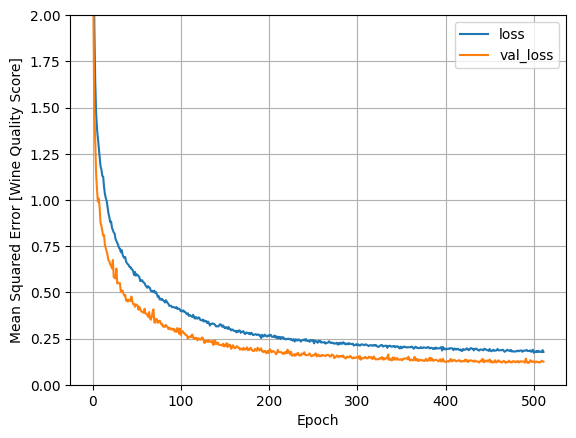

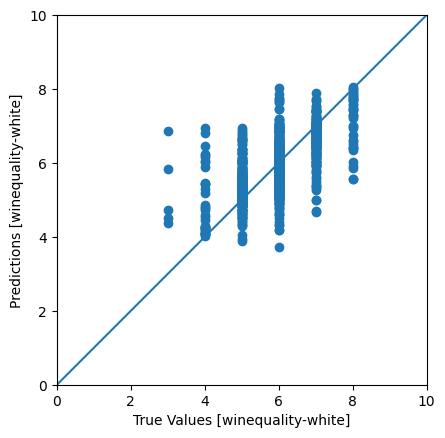

CPU times: total: 2min 21s
Wall time: 6min 28s


(array([0.96081972, 0.96919858, 0.96443683, 0.96192175, 0.95376128]),
 (<Sequential name=sequential_2, built=True>,
  <keras.src.callbacks.history.History at 0x1913e297790>))

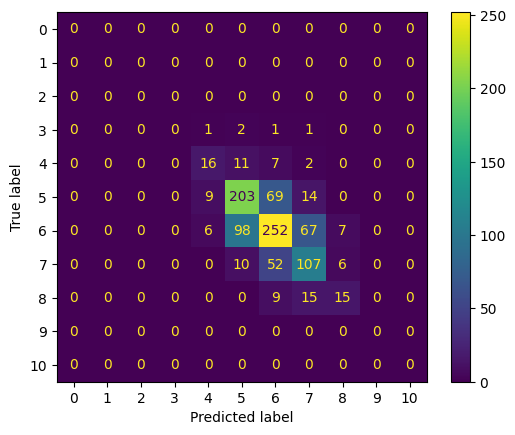

In [16]:
%%time
#Retrain best Model
best_hp = tuner.get_best_hyperparameters()[0]
best_model_history = evaluate_model_cv_print(best_hp, white_training_Data_scaled, white_training_scores, white_test_data_scaled, white_test_scores)
best_model_history

In [17]:
best_hp.values

{'lr': 0.0012332982197502966, 'num_layers': 2, 'units_0': 220, 'units_1': 206}

## RED Wine

In [18]:
red_tuner = keras_tuner.BayesianOptimization(
    hypermodel=HyperRegressor(),
    objective = keras_tuner.Objective(name="", direction='max'),
    max_trials=85,
    overwrite=False,
    directory="wine_score_training",
    project_name="red",
)

Reloading Tuner from wine_score_training\red\tuner0.json


In [19]:
red_tuner.search(
    x=red_training_Data_scaled,
    y=red_training_scores,
)

red_tuner.results_summary()

Trial 85 Complete [00h 03m 20s]
: 0.9465620756149292

Best  So Far: 0.9500704526901245
Total elapsed time: 16h 47m 24s
Results summary
Results in wine_score_training\red
Showing 10 best trials
Objective(name="", direction="max")

Trial 50 summary
Hyperparameters:
lr: 0.0017062317635702748
num_layers: 2
units_0: 158
units_1: 220
Score: 0.9500704526901245

Trial 64 summary
Hyperparameters:
lr: 0.0017259004301463411
num_layers: 2
units_0: 158
units_1: 220
Score: 0.949598515033722

Trial 33 summary
Hyperparameters:
lr: 0.0018243901560444126
num_layers: 2
units_0: 144
units_1: 168
Score: 0.9494137525558471

Trial 53 summary
Hyperparameters:
lr: 0.0031383175335364445
num_layers: 2
units_0: 186
units_1: 120
Score: 0.9489416718482971

Trial 31 summary
Hyperparameters:
lr: 0.0017178158788675895
num_layers: 2
units_0: 146
units_1: 174
Score: 0.9488247871398926

Trial 46 summary
Hyperparameters:
lr: 0.0016562356416230438
num_layers: 2
units_0: 166
units_1: 220
Score: 0.9487973213195801

Trial 39 

In [20]:
best_red_model = red_tuner.get_best_models()[0]
best_red_model.summary()

C:\GitClones\TINF21C_Maschinelles-Lernen\Programmierabgabe 2\venv\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 158)            │         1,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 158)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 220)            │        34,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,097 (144.91 KB)

 Trainable params: 37,097 (144.91 KB)

 Non-trainable params: 0 (0.00 B)


Cross Validation
- R^2: [0.94854558 0.94915199 0.94480747 0.94561279 0.9504602 ]
- R^2 Durchschnittlicher: 0.9477
- R^2 Standardabweichung: 0.0022


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
Test:
- R^2: 0.4206
- RMSE: 0.66
- MAPE: 9.10%


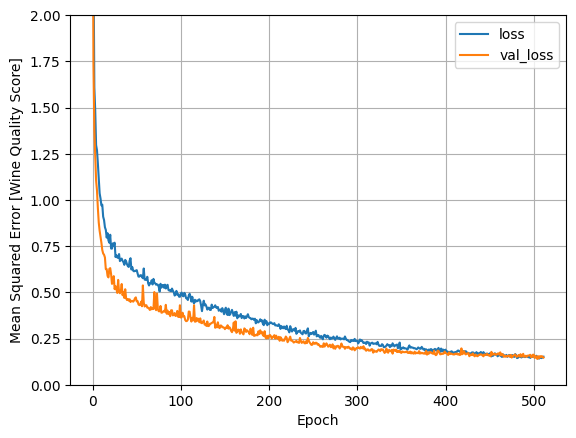

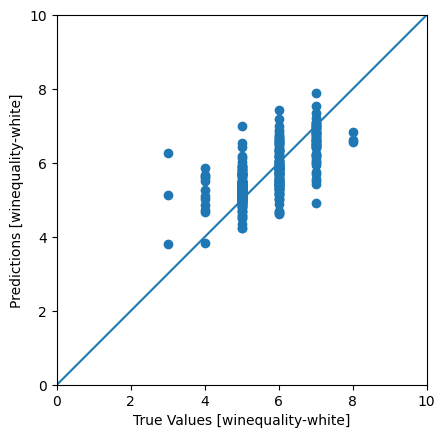

CPU times: total: 1min
Wall time: 2min 50s


(array([0.94854558, 0.94915199, 0.94480747, 0.94561279, 0.9504602 ]),
 (<Sequential name=sequential_5, built=True>,
  <keras.src.callbacks.history.History at 0x1923960f790>))

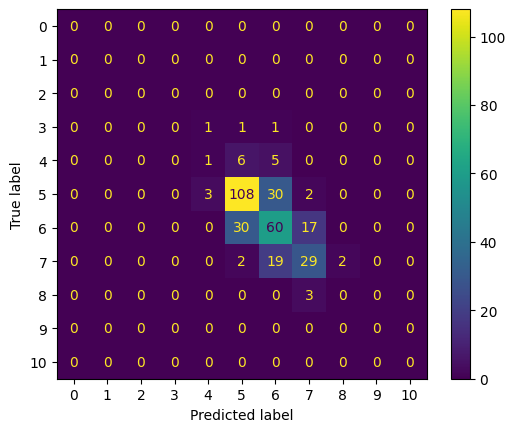

In [21]:
%%time
#Retrain best Model
best_red_hp = red_tuner.get_best_hyperparameters()[0]
best_red_model_history = evaluate_model_cv_print(best_hp, red_training_Data_scaled, red_training_scores, red_test_data_scaled, red_test_scores)
best_red_model_history

In [22]:
best_red_hp.values

{'lr': 0.0017062317635702748, 'num_layers': 2, 'units_0': 158, 'units_1': 220}